# Regression - Prediciting Life Expectancy for US

### [TBD] Now it is time to use other models to reduce the complexity of our baseline model by using several feature selection techniques. The aim here is to reduce the amount of features for our 'client', there will no doubt be some tradeoff between model accuracy and complexity.

As we can see above, we get a R2 scores of 83% for a single train-test split model and 88% if we conduct a cross-validation with 5 splits. This however might result in a model that is too complex noting the number of features we have. Let's conduct two different ways of selecting only the best features:
- filter methods
    - low variance
    - Pearson's Correlation (Given majority of our features are continuous)
- wrapper methods
    - Recurvsive Feature Elimination
    - Stepwise Selection
- embedded methods 
    - Lasso

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from functions import *

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, KFold
from sklearn.metrics import r2_score
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV, RFE
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor

from scipy import stats

sns.set_style('darkgrid')
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

%load_ext autoreload
%autoreload 2

In [2]:
df_clean = pd.read_csv('clean_data.csv', index_col=[0])

In [3]:
to_drop = ['State_Abbreviation', 'Name', 'Life_expectancy']
X = df_clean.drop(to_drop, axis = 1)
y = df_clean['Life_expectancy']

In [4]:
sc = StandardScaler()
to_scale = df_clean.drop(['State_Abbreviation', 'Name'], axis = 1)
Scaled_data = sc.fit_transform(to_scale)
Scaled_data_df = pd.DataFrame(Scaled_data, columns = [to_scale.columns])

X_scaled = Scaled_data_df.drop('Life_expectancy', axis = 1)
y_scaled = Scaled_data_df['Life_expectancy'].values

Split into training and testing dataset, followed by a subsequent split within the training bucket into training and validation

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size = 0.25, random_state = 1)
X_train_subset, X_val, y_train_subset, y_val = train_test_split(X_train, y_train, test_size = 0.25, random_state = 1)

In [66]:
print ('Total training data:', len(X_train_subset))
print ('Total validation data:', len(X_val))
print ('Total test date:', len(X_test))
print ('Total data:', len(X))
print ('Cross check:',  len(X) == len(X_train_subset) + len(X_val) + len(X_test))

Total training data: 1767
Total validation data: 589
Total test date: 786
Total data: 3142
Cross check: True


Create a dataframe to store all model outcomes which will be useful to derive a conclusion at a later stage

In [67]:
all_model_summary_df = pd.DataFrame([], columns = ['model', 'R2_test', 'AIC', 'n_features', '>0.05_pvalues'])
all_model_summary_df['model'] = ['Baseline', 'Basic - Top Correlation',
                                 'Filter', 
                                 'Wrappper - RFE', 'Wrappper - Stepwise',
                                 'Embedded - Lasso',
                                ]

### 1. Baseline model - All available features

This is a very basic model which accounts for all 76 features purely using the X_train dataset (no validation)

In [68]:
baseline_OLS = OLS(y_train, add_constant(X_train)).fit()

baseline_predictions = baseline_OLS.predict(add_constant(X_test))
baseline_train_r2 = baseline_OLS.rsquared

baseline_test_r2 = r2_score(y_test, baseline_predictions)

In [69]:
baseline_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.911
Model:                            OLS   Adj. R-squared:                  0.908
Method:                 Least Squares   F-statistic:                     377.5
Date:                Mon, 13 Jan 2020   Prob (F-statistic):               0.00
Time:                        10:41:25   Log-Likelihood:                -479.33
No. Observations:                2356   AIC:                             1085.
Df Residuals:                    2293   BIC:                             1448.
Df Model:                          62                                         
Covariance Type:            nonrobust                                         
=============================================================================================================================================
                                                                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------------------
const                                                                        -0.0075      0.006     -1.201      0.230      -0.020       0.005
('Release_Year',)                                                         -1.441e-14   2.34e-15     -6.160      0.000    -1.9e-14   -9.82e-15
('County_Ranked_(Yes=1/No=0)',)                                               0.0067      0.008      0.874      0.382      -0.008       0.022
('Premature_death',)                                                         -0.0332      0.026     -1.292      0.196      -0.084       0.017
('Poor_or_fair_health',)                                                      0.0574      0.028      2.016      0.044       0.002       0.113
('Poor_physical_health_days',)                                               -0.1236      0.063     -1.951      0.051      -0.248       0.001
('Poor_mental_health_days',)                                                 -0.0629      0.041     -1.530      0.126      -0.143       0.018
('Low_birthweight',)                                                         -0.0162      0.011     -1.518      0.129      -0.037       0.005
('Adult_smoking',)                                                           -0.0408      0.017     -2.453      0.014      -0.073      -0.008
('Adult_obesity',)                                                           -0.0154      0.011     -1.423      0.155      -0.037       0.006
('Food_environment_index',)                                                  -0.0836      0.123     -0.681      0.496      -0.324       0.157
('Physical_inactivity',)                                                     -0.0066      0.012     -0.532      0.595      -0.031       0.018
('Access_to_exercise_opportunities',)                                        -0.0275      0.009     -3.016      0.003      -0.045      -0.010
('Excessive_drinking',)                                                       0.0159      0.012      1.372      0.170      -0.007       0.039
('Alcohol-impaired_driving_deaths',)                                         -0.0036      0.006     -0.565      0.572      -0.016       0.009
('Sexually_transmitted_infections',)                                         -0.0008      0.010     -0.082      0.935      -0.020       0.018
('Teen_births',)                                                              0.0084      0.013      0.636      0.525      -0.018       0.034
('Uninsured',)                                                                1.7326      0.147     11.804      0.000       1.445       2.020
('Primary_care_physicians',)                                                 -0.0378      0.010     -

Now, let's check the R2 of the train and test sets as well as plot the residuals

In [72]:
baseline_errors = y_test - baseline_predictions

print ('Baseline Train R-Squared:', round(baseline_train_r2, 2))
print ('Baseline Test R-Squared:', round(baseline_test_r2, 2))

print ('\n')

print ('Check for Homoscedasticity Assumption')
plt.figure(figsize = (6,4))
plt.scatter(x = y_test, y = baseline_errors)
plt.show()

print ('Check for Residuals Normality')
fig = sm.graphics.qqplot(baseline_OLS.resid, dist=stats.norm, line='45', fit=True)

Exception: Data must be 1-dimensional

Rule of thumb threshold is VIF at the level of 2.5, meaning if the VIF is above 2.5 you should consider there is effect of multicollinearity on your fitted model

In [11]:
X_baseline = X_train
X_baseline['Intercept'] = 1

Baseline_VIF = pd.DataFrame()
Baseline_VIF["variables"] = X_baseline.columns
Baseline_VIF["VIF"] = [variance_inflation_factor(X_baseline.values, i) for i in range(X_baseline.shape[1])]

baseline_correlated_features = sum(Baseline_VIF['VIF'] > 5)
baseline_correlated_features

22

In [12]:
all_model_summary_df.loc[all_model_summary_df.model == 'Baseline', 'n_features'] = len(baseline_OLS.pvalues)
all_model_summary_df.loc[all_model_summary_df.model == 'Baseline', 'AIC'] = baseline_OLS.aic
all_model_summary_df.loc[all_model_summary_df.model == 'Baseline', 'R2_test'] = baseline_test_r2
all_model_summary_df.loc[all_model_summary_df.model == 'Baseline', '>0.05_pvalues'] = sum(baseline_OLS.pvalues > 0.05)

In [13]:
all_model_summary_df

,model,R2_test,AIC,n_features,>0.05_pvalues
0,Baseline,0.839762,6211.72,63,40
1,Basic - Top Correlation,NaN,NaN,NaN,NaN
2,Filter,NaN,NaN,NaN,NaN
3,Wrappper - RFE,NaN,NaN,NaN,NaN
4,Wrappper - Stepwise,NaN,NaN,NaN,NaN
5,Embedded - Lasso,NaN,NaN,NaN,NaN


### 2. Basic - Features with Highest Correlation with Target

Given we've blindly included all features in the baseline model, let's try and narrow these down to only include features which are highly correlated with 'Life Expectancy'. First, we initiated a correlation matrix and set our target correlation threshold to 0.65.

In [14]:
initial_matrix = abs(df_clean.corr().Life_expectancy)

target_correlation_threshold = 0.65

final = list(initial_matrix[(initial_matrix.sort_values(ascending=False) > target_correlation_threshold)].index)
final.remove('Life_expectancy')
final

['Premature_death',
 'Poor_physical_health_days',
 'Adult_smoking',
 'Premature_age-adjusted_mortality',
 'Frequent_physical_distress',
 'Frequent_mental_distress']

Using a 0.65 threshold, we've narrowed down our features from 76 to 6 features. Using these 6 features, let's create another OLS model and evaluate its performance.

In [15]:
basic_correlation_OLS = OLS(y_train, add_constant(X_train[final])).fit()

basic_predictions = basic_correlation_OLS.predict(add_constant(X_test[final]))
basic_train_r2 = basic_correlation_OLS.rsquared

basic_test_r2 = r2_score(y_test, basic_predictions)

In [16]:
basic_correlation_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Life_expectancy   R-squared:                       0.885
Model:                            OLS   Adj. R-squared:                  0.885
Method:                 Least Squares   F-statistic:                     3007.
Date:                Mon, 13 Jan 2020   Prob (F-statistic):               0.00
Time:                        10:37:21   Log-Likelihood:                -3343.8
No. Observations:                2356   AIC:                             6702.
Df Residuals:                    2349   BIC:                             6742.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const                               88.5765      0.157    565.278      0.000      88.269      88.884
Premature_death                   2.108e-05   2.55e-05      0.826      0.409   -2.89e-05    7.11e-05
Poor_physical_health_days           -1.1767      0.163     -7.224      0.000      -1.496      -0.857
Adult_smoking                       -6.4842      1.060     -6.117      0.000      -8.563      -4.405
Premature_age-adjusted_mortality    -0.0242      0.001    -37.377      0.000      -0.026      -0.023
Frequent_physical_distress          58.1358      5.056     11.498      0.000      48.221      68.050
Frequent_mental_distress           -21.7542      4.001     -5.438      0.000     -29.599     -13.909
==============================================================================
Omnibus:                     2330.297   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           171800.511
Skew:                           4.630   Prob(JB):                         0.00
Kurtosis:                      43.796   Cond. No.                     2.27e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.27e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Looks like the 'Premature_death' feature is not significant according its p-value. Let's re-run the model again excluding this feature.

In [17]:
final.remove('Premature_death')
final

['Poor_physical_health_days',
 'Adult_smoking',
 'Premature_age-adjusted_mortality',
 'Frequent_physical_distress',
 'Frequent_mental_distress']

In [18]:
basic_correlation_OLS = OLS(y_train, add_constant(X_train[final])).fit()

basic_predictions = basic_correlation_OLS.predict(add_constant(X_test[final]))
basic_train_r2 = basic_correlation_OLS.rsquared

basic_test_r2 = r2_score(y_test, basic_predictions)

In [19]:
basic_correlation_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Life_expectancy   R-squared:                       0.885
Model:                            OLS   Adj. R-squared:                  0.885
Method:                 Least Squares   F-statistic:                     3609.
Date:                Mon, 13 Jan 2020   Prob (F-statistic):               0.00
Time:                        10:37:21   Log-Likelihood:                -3344.2
No. Observations:                2356   AIC:                             6700.
Df Residuals:                    2350   BIC:                             6735.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const                               88.5568      0.155    571.848      0.000      88.253      88.861
Poor_physical_health_days           -1.1993      0.161     -7.469      0.000      -1.514      -0.884
Adult_smoking                       -6.5190      1.059     -6.155      0.000      -8.596      -4.442
Premature_age-adjusted_mortality    -0.0238      0.000    -84.558      0.000      -0.024      -0.023
Frequent_physical_distress          58.4547      5.041     11.596      0.000      48.570      68.340
Frequent_mental_distress           -21.2764      3.958     -5.375      0.000     -29.038     -13.514
==============================================================================
Omnibus:                     2347.908   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           176856.921
Skew:                           4.682   Prob(JB):                         0.00
Kurtosis:                      44.399   Cond. No.                     1.08e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.08e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Good, dropping the feature does not impact our R2. Let's now conduct further analysis on the R-Squares, Residuals' Homoscedasticity and Normality

Basic Train R-Squared: 0.88
Basic Test R-Squared: 0.82


Check for Homoscedasticity Assumption


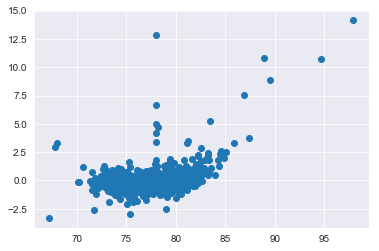

Check for Residuals Normality


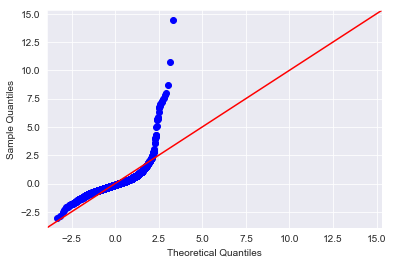

In [20]:
basic_errors = y_test - basic_predictions

print ('Basic Train R-Squared:', round(basic_train_r2, 2))
print ('Basic Test R-Squared:', round(basic_test_r2, 2))

print ('\n')

print ('Check for Homoscedasticity Assumption')
plt.figure(figsize = (6,4))
plt.scatter(x = y_test, y = basic_errors)
plt.show()

print ('Check for Residuals Normality')
fig = sm.graphics.qqplot(basic_correlation_OLS.resid, dist=stats.norm, line='45', fit=True)

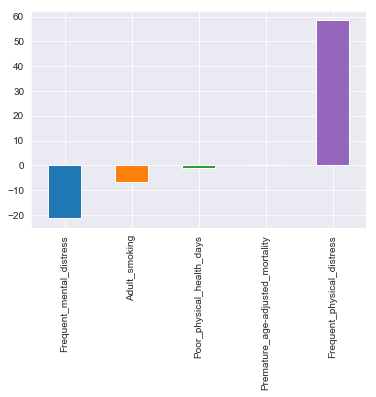

In [21]:
coef_basic = basic_correlation_OLS.params.sort_values()
coef_basic[:5].plot(kind = 'bar', figsize = (6,4))
plt.show()

In [22]:
all_model_summary_df.loc[all_model_summary_df.model == 'Basic - Top Correlation', 'n_features'] = len(basic_correlation_OLS.pvalues)
all_model_summary_df.loc[all_model_summary_df.model == 'Basic - Top Correlation', 'AIC'] = basic_correlation_OLS.aic
all_model_summary_df.loc[all_model_summary_df.model == 'Basic - Top Correlation', 'R2_test'] = basic_test_r2
all_model_summary_df.loc[all_model_summary_df.model == 'Basic - Top Correlation', '>0.05_pvalues'] = sum(basic_correlation_OLS.pvalues > 0.05)

In [23]:
all_model_summary_df

,model,R2_test,AIC,n_features,>0.05_pvalues
0,Baseline,0.839762,6211.72,63,40
1,Basic - Top Correlation,0.817139,6700.37,6,0
2,Filter,NaN,NaN,NaN,NaN
3,Wrappper - RFE,NaN,NaN,NaN,NaN
4,Wrappper - Stepwise,NaN,NaN,NaN,NaN
5,Embedded - Lasso,NaN,NaN,NaN,NaN


Just by using the 6 top correlated features, we get almost similar results to our Baseline model and is much more user friendly for our client!

### 3. Filter Method - drop features with no or low variance & high correlation with other features

One of the pitfalls of the above method is that we might have potentially ignored other useful features that might be of use to our client. Also, the baseline model might include various highly correlated features which violates the assumptions of a regression model. As such, let's try out best to find a middle ground by using the filter methods, first by:

- dropping features with no or low variance. These features typically do not add much predictive value
- dropping features which are highly correlated

Let's start of by dropping features with no or low variance. We can use Sklearn's variance threshold tool to remove features with low threshold (we set it at 0.025).

In [24]:
variance_threshold = 0.00

low_var_filter = VarianceThreshold(threshold = variance_threshold)
low_var_filter.fit(X_train)

VarianceThreshold(threshold=0.0)

In [25]:
dropped_cols = X_train.columns[low_var_filter.get_support() == False]
print ('Number of low variance features:', len(dropped_cols))

Number of low variance features: 2


In [26]:
High_Var_Features = X_train.drop(dropped_cols, axis = 1)

Now we have removed them, let's further narrow down features by excluding highly correlated features. We have defined highly correlated features as those with pearson's r of 0.7 or more

In [27]:
corr_matrix = High_Var_Features.corr()
correlated_features = set()

corr_threshold = 0.7

for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > corr_threshold:
            colname = corr_matrix.columns[i]
            correlated_features.add(colname)

correlated_features

{'Adult_smoking',
 'Children_eligible_for_free_or_reduced_price_lunch',
 'Children_in_poverty',
 'Diabetes_prevalence',
 'Food_insecurity',
 'Frequent_mental_distress',
 'Frequent_physical_distress',
 'Limited_access_to_healthy_foods',
 'Median_household_income',
 'Percentage_of_households_with_high_housing_costs',
 'Poor_mental_health_days',
 'Poor_physical_health_days',
 'Premature_age-adjusted_mortality',
 'Severe_housing_cost_burden',
 'Teen_births',
 'Uninsured_adults',
 'Uninsured_children'}

In [28]:
High_Var_Features_Low_Corr = High_Var_Features.drop(list(correlated_features), axis = 1)

In [29]:
filter_OLS = OLS(y_train, add_constant(X_train[High_Var_Features_Low_Corr.columns])).fit()

filter_predictions = filter_OLS.predict(add_constant(X_test[High_Var_Features_Low_Corr.columns]))
filter_train_r2 = filter_OLS.rsquared

filter_test_r2 = r2_score(y_test, filter_predictions)

In [30]:
filter_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Life_expectancy   R-squared:                       0.858
Model:                            OLS   Adj. R-squared:                  0.856
Method:                 Least Squares   F-statistic:                     311.4
Date:                Mon, 13 Jan 2020   Prob (F-statistic):               0.00
Time:                        10:37:21   Log-Likelihood:                -3586.3
No. Observations:                2356   AIC:                             7265.
Df Residuals:                    2310   BIC:                             7530.
Df Model:                          45                                         
Covariance Type:            nonrobust                                         
========================================================================================================================================
                                                                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------------------
const                                                                   88.1655      0.972     90.696      0.000      86.259      90.072
County_Ranked_(Yes=1/No=0)                                               0.4745      0.201      2.355      0.019       0.079       0.870
Premature_death                                                         -0.0008   1.82e-05    -41.756      0.000      -0.001      -0.001
Poor_or_fair_health                                                     -1.9213      1.299     -1.479      0.139      -4.469       0.626
Low_birthweight                                                         -2.2735      1.492     -1.524      0.128      -5.198       0.651
Adult_obesity                                                           -1.9606      0.809     -2.422      0.015      -3.548      -0.373
Food_environment_index                                                  -0.0779      0.032     -2.406      0.016      -0.141      -0.014
Physical_inactivity                                                     -4.5575      0.832     -5.478      0.000      -6.189      -2.926
Access_to_exercise_opportunities                                         0.0500      0.145      0.345      0.730      -0.235       0.335
Excessive_drinking                                                      -1.0516      1.174     -0.896      0.370      -3.354       1.251
Alcohol-impaired_driving_deaths                                          0.1491      0.153      0.977      0.329      -0.150       0.448
Sexually_transmitted_infections                                        4.65e-05      0.000      0.329      0.742      -0.000       0.000
Uninsured                                                                0.6666      0.706      0.945      0.345      -0.717       2.050
Primary_care_physicians                                               -151.7479     98.164     -1.546      0.122    -344.247      40.752
Dentists                                                                 3.7434     95.819      0.039      0.969    -184.158     191.645
Mental_health_providers                                                -39.6564     19.272     -2.058      0.040     -77.448      -1.865
Preventable_hospital_stays                                           -6.248e-05    1.5e-05     -4.172      0.000   -9.19e-05   -3.31e-05
Mammography_screening                                                    0.4619      0.408      1.133      0.257      -0.338       1.262
Flu_vaccinations                                                        -0.0900      0.318     -0.283      0.777      -0.713       0.533
High_school_graduation                                               

Looks like there are more features with high p-values. Once again, let's remove them and refit the model

In [31]:
updated_filter_features = filter_OLS.pvalues
updated_filter_features = updated_filter_features[updated_filter_features < 0.05]
updated_filter_features.drop('const', axis = 0, inplace = True)
updated_filter_features.index

Index(['County_Ranked_(Yes=1/No=0)', 'Premature_death', 'Adult_obesity',
       'Food_environment_index', 'Physical_inactivity',
       'Mental_health_providers', 'Preventable_hospital_stays', 'Some_college',
       'Income_inequality', 'Children_in_single-parent_households',
       'Social_associations', 'Violent_crime', 'Injury_deaths',
       'Air_pollution_-_particulate_matter',
       'Percentage_of_households_with_overcrowding', 'Driving_alone_to_work',
       'Motor_vehicle_crash_deaths', 'Homeownership', 'Population',
       '%_not_proficient_in_English', '%_Rural'],
      dtype='object')

In [32]:
filter_OLS = OLS(y_train, add_constant(X_train[updated_filter_features.index])).fit()

filter_predictions = filter_OLS.predict(add_constant(X_test[updated_filter_features.index]))
filter_train_r2 = filter_OLS.rsquared

filter_test_r2 = r2_score(y_test, filter_predictions)

In [33]:
filter_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Life_expectancy   R-squared:                       0.857
Model:                            OLS   Adj. R-squared:                  0.856
Method:                 Least Squares   F-statistic:                     666.6
Date:                Mon, 13 Jan 2020   Prob (F-statistic):               0.00
Time:                        10:37:22   Log-Likelihood:                -3597.8
No. Observations:                2356   AIC:                             7240.
Df Residuals:                    2334   BIC:                             7366.
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
==============================================================================================================
                                                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
const                                         87.9726      0.589    149.302      0.000      86.817      89.128
County_Ranked_(Yes=1/No=0)                     0.3163      0.185      1.709      0.088      -0.047       0.679
Premature_death                               -0.0008   1.69e-05    -45.229      0.000      -0.001      -0.001
Adult_obesity                                 -1.8573      0.754     -2.464      0.014      -3.336      -0.379
Food_environment_index                        -0.0745      0.028     -2.623      0.009      -0.130      -0.019
Physical_inactivity                           -4.8783      0.758     -6.436      0.000      -6.365      -3.392
Mental_health_providers                      -52.2558     17.570     -2.974      0.003     -86.709     -17.802
Preventable_hospital_stays                 -6.878e-05   1.44e-05     -4.768      0.000   -9.71e-05   -4.05e-05
Some_college                                   2.5480      0.300      8.497      0.000       1.960       3.136
Income_inequality                              0.0647      0.040      1.636      0.102      -0.013       0.142
Children_in_single-parent_households           0.6258      0.326      1.917      0.055      -0.014       1.266
Social_associations                           -0.0045      0.004     -1.216      0.224      -0.012       0.003
Violent_crime                                 -0.0005      0.000     -3.055      0.002      -0.001      -0.000
Injury_deaths                                 -0.0040      0.001     -2.743      0.006      -0.007      -0.001
Air_pollution_-_particulate_matter            -0.1316      0.016     -8.407      0.000      -0.162      -0.101
Percentage_of_households_with_overcrowding    -5.2203      1.354     -3.855      0.000      -7.876      -2.565
Driving_alone_to_work                         -4.3104      0.434     -9.935      0.000      -5.161      -3.460
Motor_vehicle_crash_deaths                    -0.0128      0.004     -3.406      0.001      -0.020      -0.005
Homeownership                                  1.9589      0.414      4.730      0.000       1.147       2.771
Population                                  2.348e-07   7.89e-08      2.974      0.003       8e-08     3.9e-07
%_not_proficient_in_English                   11.1640      1.095     10.195      0.000       9.017      13.311
%_Rural                                        0.5823      0.122      4.783      0.000       0.344       0.821
==============================================================================
Omnibus:                     1960.406   Durbin-Watson:                   1.987
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           117230.230
Skew:                           3.524   Prob(JB):                      

Filter Train R-Squared: 0.86
Filter Test R-Squared: 0.78


Check for Homoscedasticity Assumption


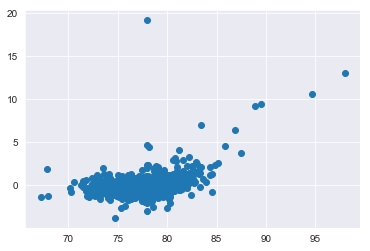

Check for Residuals Normality


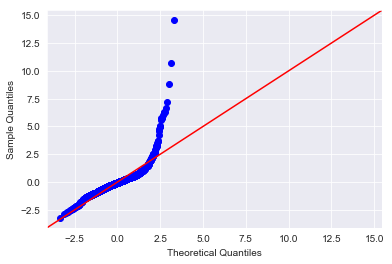

In [34]:
filter_errors = y_test - filter_predictions

print ('Filter Train R-Squared:', round(filter_train_r2, 2))
print ('Filter Test R-Squared:', round(filter_test_r2, 2))

print ('\n')

print ('Check for Homoscedasticity Assumption')
plt.figure(figsize = (6,4))
plt.scatter(x = y_test, y = filter_errors)
plt.show()

print ('Check for Residuals Normality')
fig = sm.graphics.qqplot(filter_OLS.resid, dist=stats.norm, line='45', fit=True)

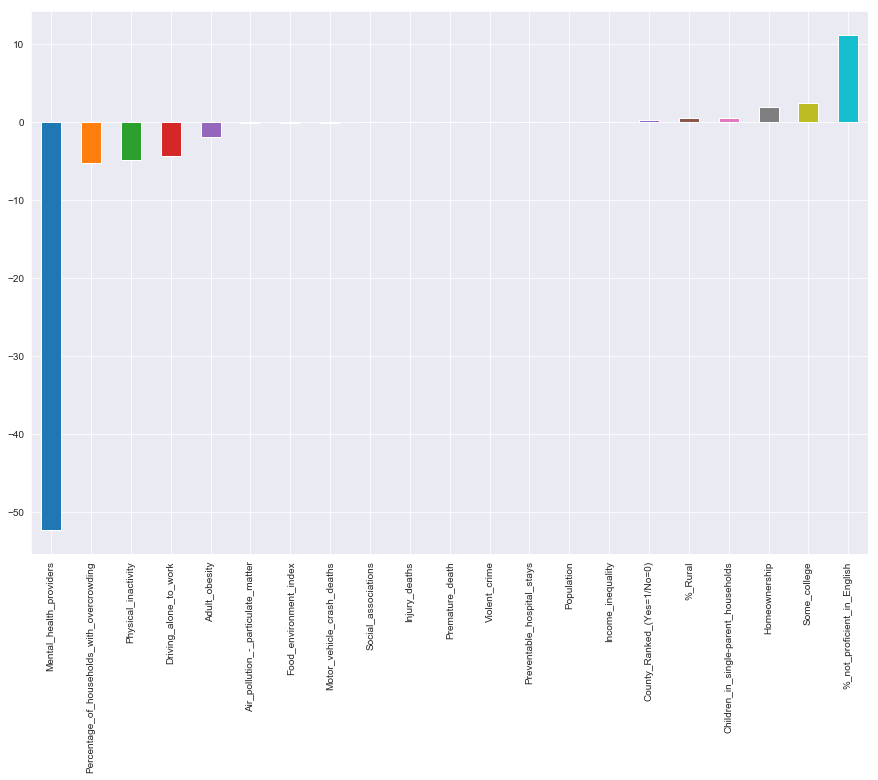

In [35]:
coef_filter = filter_OLS.params.sort_values()
coef_filter[:-1].plot(kind = 'bar', figsize = (15,10))
plt.show()

In [36]:
all_model_summary_df.loc[all_model_summary_df.model == 'Filter', 'n_features'] = len(filter_OLS.pvalues)
all_model_summary_df.loc[all_model_summary_df.model == 'Filter', 'AIC'] = filter_OLS.aic
all_model_summary_df.loc[all_model_summary_df.model == 'Filter', 'R2_test'] = filter_test_r2
all_model_summary_df.loc[all_model_summary_df.model == 'Filter', '>0.05_pvalues'] = sum(filter_OLS.pvalues > 0.05)

In [37]:
all_model_summary_df

,model,R2_test,AIC,n_features,>0.05_pvalues
0,Baseline,0.839762,6211.72,63,40
1,Basic - Top Correlation,0.817139,6700.37,6,0
2,Filter,0.782496,7239.67,22,4
3,Wrappper - RFE,NaN,NaN,NaN,NaN
4,Wrappper - Stepwise,NaN,NaN,NaN,NaN
5,Embedded - Lasso,NaN,NaN,NaN,NaN


### 4. Wrapper - Recursive Feature Elimination

In [38]:
linreg = LinearRegression()
rfecv = RFECV(linreg, step = 1, scoring='r2', cv=10)
rfecv.fit(X_train, y_train)

RFECV(cv=10,
      estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                 normalize=False),
      min_features_to_select=1, n_jobs=None, scoring='r2', step=1, verbose=0)

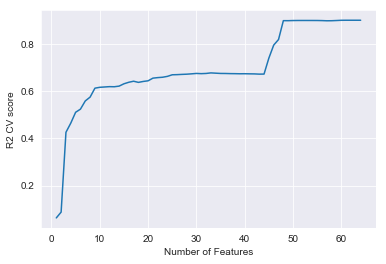

In [39]:
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.xlabel('Number of Features')
plt.ylabel('R2 CV score')
plt.show()

In [40]:
to_include = X_train.columns[rfecv.get_support()]

In [41]:
RFE_test_r2 = statsmodel_regression(X_train[to_include], add_constant(X_test[to_include]), y_train, y_test)[0]
RFE_estimator = statsmodel_regression(X_train[to_include], add_constant(X_test[to_include]), y_train, y_test)[1]

In [42]:
all_model_summary_df.loc[all_model_summary_df.model == 'Wrappper - RFE', 'n_features'] = len(RFE_estimator.pvalues)
all_model_summary_df.loc[all_model_summary_df.model == 'Wrappper - RFE', 'AIC'] = RFE_estimator.aic
all_model_summary_df.loc[all_model_summary_df.model == 'Wrappper - RFE', 'R2_test'] = RFE_test_r2
all_model_summary_df.loc[all_model_summary_df.model == 'Wrappper - RFE', '>0.05_pvalues'] = sum(RFE_estimator.pvalues > 0.05)

In [43]:
all_model_summary_df

,model,R2_test,AIC,n_features,>0.05_pvalues
0,Baseline,0.839762,6211.72,63,40
1,Basic - Top Correlation,0.817139,6700.37,6,0
2,Filter,0.782496,7239.67,22,4
3,Wrappper - RFE,0.84,6210.68,62,39
4,Wrappper - Stepwise,NaN,NaN,NaN,NaN
5,Embedded - Lasso,NaN,NaN,NaN,NaN


### 5. Stepwise Selection - Combination of Forward and Backward feature selection

In [44]:
stepwise_columns = stepwise_selection(X_train, y_train, threshold_in = 0.01, verbose=True)

Add  Release_Year                   with p-value 0.0
Add  Adult_smoking                  with p-value 0.0
Add  Premature_age-adjusted_mortality with p-value 0.0
Add  Intercept                      with p-value 0.0
Add  Driving_alone_to_work          with p-value 1.29505e-41
Add  Poor_or_fair_health            with p-value 1.36605e-14
Add  Air_pollution_-_particulate_matter with p-value 1.1696e-11
Add  Child_mortality                with p-value 3.03405e-11
Add  Poor_mental_health_days        with p-value 1.82889e-07
Add  Percentage_of_households_with_overcrowding with p-value 3.85548e-07
Add  Median_household_income        with p-value 2.48332e-06
Add  Limited_access_to_healthy_foods with p-value 2.21094e-06
Add  Income_inequality              with p-value 8.33865e-05
Add  %_not_proficient_in_English    with p-value 3.60029e-05
Add  %_Rural                        with p-value 2.69338e-05
Add  Motor_vehicle_crash_deaths     with p-value 0.00115029


In [45]:
stepwise_columns.remove('Intercept')

In [46]:
stepwise_OLS = OLS(y_train, add_constant(X_train[stepwise_columns])).fit()

stepwise_predictions = stepwise_OLS.predict(add_constant(X_test[stepwise_columns]))
stepwise_train_r2 = stepwise_OLS.rsquared

stepwise_test_r2 = r2_score(y_test, stepwise_predictions)

In [47]:
stepwise_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Life_expectancy   R-squared:                       0.901
Model:                            OLS   Adj. R-squared:                  0.900
Method:                 Least Squares   F-statistic:                     1518.
Date:                Mon, 13 Jan 2020   Prob (F-statistic):               0.00
Time:                        10:37:28   Log-Likelihood:                -3168.0
No. Observations:                2356   AIC:                             6366.
Df Residuals:                    2341   BIC:                             6453.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==============================================================================================================
                                                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
Release_Year                                   0.0440      0.000    223.274      0.000       0.044       0.044
Adult_smoking                                 -2.5498      1.030     -2.475      0.013      -4.570      -0.530
Premature_age-adjusted_mortality              -0.0224      0.000    -71.297      0.000      -0.023      -0.022
Driving_alone_to_work                         -3.0549      0.330     -9.266      0.000      -3.701      -2.408
Poor_or_fair_health                            6.2914      1.046      6.015      0.000       4.240       8.342
Air_pollution_-_particulate_matter            -0.0754      0.013     -5.937      0.000      -0.100      -0.050
Child_mortality                               -0.0057      0.001     -4.825      0.000      -0.008      -0.003
Poor_mental_health_days                       -0.2400      0.056     -4.290      0.000      -0.350      -0.130
Percentage_of_households_with_overcrowding    -8.0438      1.124     -7.158      0.000     -10.248      -5.840
Median_household_income                     1.462e-05   2.45e-06      5.963      0.000    9.81e-06    1.94e-05
Limited_access_to_healthy_foods                1.3084      0.260      5.037      0.000       0.799       1.818
Income_inequality                              0.1591      0.032      4.919      0.000       0.096       0.222
%_not_proficient_in_English                    4.9832      1.016      4.905      0.000       2.991       6.975
%_Rural                                        0.4232      0.082      5.176      0.000       0.263       0.584
Motor_vehicle_crash_deaths                    -0.0099      0.003     -3.255      0.001      -0.016      -0.004
==============================================================================
Omnibus:                     1965.282   Durbin-Watson:                   2.012
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            90522.473
Skew:                           3.641   Prob(JB):                         0.00
Kurtosis:                      32.480   Cond. No.                     3.97e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.97e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Basic Train R-Squared: 0.9
Basic Test R-Squared: 0.84


Check for Homoscedasticity Assumption


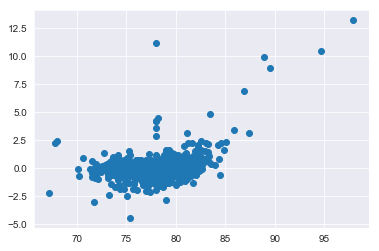

Check for Residuals Normality


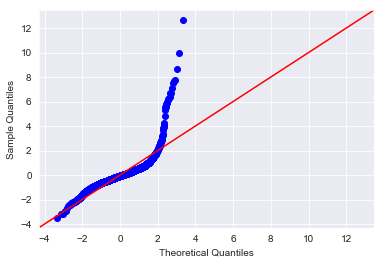

In [48]:
stepwise_errors = y_test - stepwise_predictions

print ('Basic Train R-Squared:', round(stepwise_train_r2, 2))
print ('Basic Test R-Squared:', round(stepwise_test_r2, 2))

print ('\n')

print ('Check for Homoscedasticity Assumption')
plt.figure(figsize = (6,4))
plt.scatter(x = y_test, y = stepwise_errors)
plt.show()

print ('Check for Residuals Normality')
fig = sm.graphics.qqplot(stepwise_OLS.resid, dist=stats.norm, line='45', fit=True)

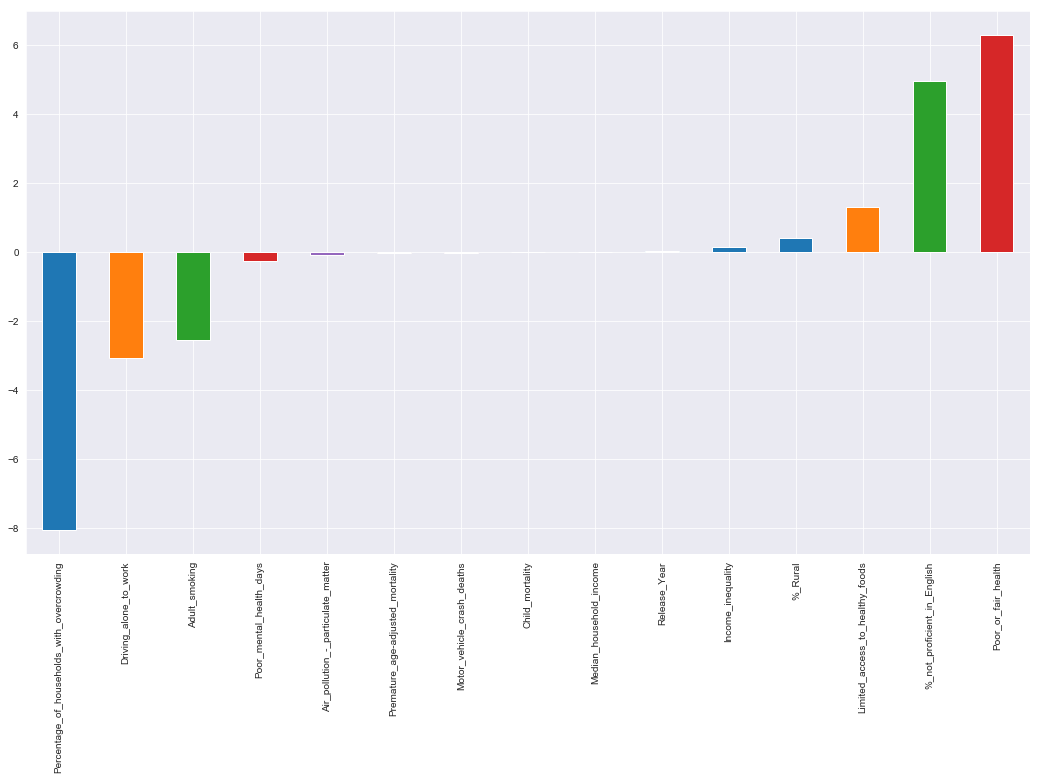

In [49]:
stepwise_OLS.params.sort_values().plot(kind = 'bar', figsize = (18,10))
plt.show()

In [50]:
all_model_summary_df.loc[all_model_summary_df.model == 'Wrappper - Stepwise', 'n_features'] = len(stepwise_OLS.pvalues)
all_model_summary_df.loc[all_model_summary_df.model == 'Wrappper - Stepwise', 'AIC'] = stepwise_OLS.aic
all_model_summary_df.loc[all_model_summary_df.model == 'Wrappper - Stepwise', 'R2_test'] = stepwise_test_r2
all_model_summary_df.loc[all_model_summary_df.model == 'Wrappper - Stepwise', '>0.05_pvalues'] = sum(stepwise_OLS.pvalues > 0.05)

In [51]:
all_model_summary_df

,model,R2_test,AIC,n_features,>0.05_pvalues
0,Baseline,0.839762,6211.72,63,40
1,Basic - Top Correlation,0.817139,6700.37,6,0
2,Filter,0.782496,7239.67,22,4
3,Wrappper - RFE,0.84,6210.68,62,39
4,Wrappper - Stepwise,0.838352,6366.06,15,0
5,Embedded - Lasso,NaN,NaN,NaN,NaN


### 6. Embedded - Lasso L2 Regression

First we set the all the hyperparameters we are interested in tuning, primarily the 'penalizing' parameters (alpha). The GridSearch function will be able to obtain the best parameters for us by evaluating them using R2 score.

In [52]:
model = Lasso()
lasso_params = {'alpha' : [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75],
                'fit_intercept': [True, False],
                'normalize' : [True, False]}

grid_obj = GridSearchCV(estimator = model, 
                        param_grid = lasso_params, 
                        scoring = 'r2',
                        cv = 5,
                        n_jobs = -1)

grid_obj = grid_obj.fit(X_train_subset, y_train_subset)
grid_obj.best_params_

{'alpha': 0.05, 'fit_intercept': True, 'normalize': False}

Looks like the best alpha level is 0.05. Let's use the above best selected parameters and train it on our subset of X_train data and subsequently test them on the validation dataset.

In [53]:
final_lasso = grid_obj.best_estimator_.fit(X_train_subset, y_train_subset)

train_predictions = final_lasso.predict(X_train_subset)
val_predictions = final_lasso.predict(X_val)
test_predictions = final_lasso.predict(X_test)

print ('Train R2 score of:', round(r2_score(y_train_subset, train_predictions),2))
print ('Validation R2 score of:', round(r2_score(y_val, val_predictions),2))
print ('Test R2 score of:', round(r2_score(y_test, test_predictions),2))

Train R2 score of: 0.89
Validation R2 score of: 0.9
Test R2 score of: 0.83


Not bad at all. Now let's explore the coefficients that the Lasso model chose and plot them.

Lasso picked 18 variables and eliminated the other 45 variables


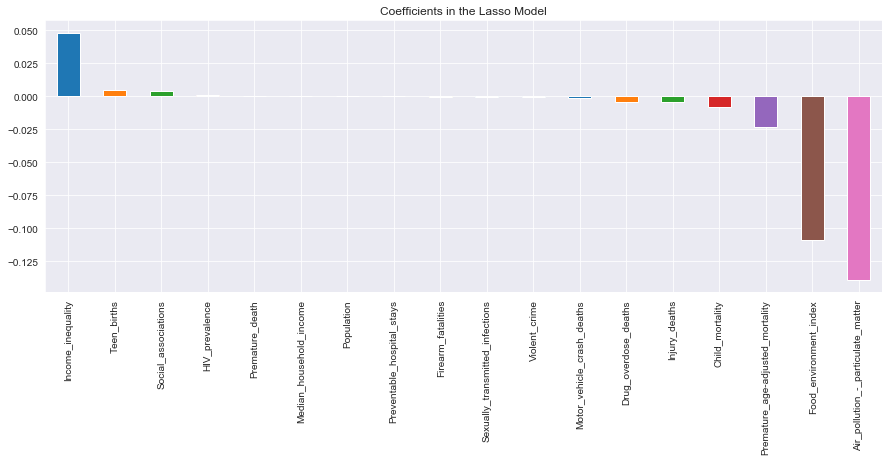

In [54]:
coef = pd.Series(final_lasso.coef_, index = X_train_subset.columns)
final_coef = coef[coef != 0]
final_coef.sort_values(ascending = False, inplace=True)

print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

final_coef.plot(kind = "bar", figsize=(15,5))
plt.title("Coefficients in the Lasso Model")
plt.show()

How about the residuals?

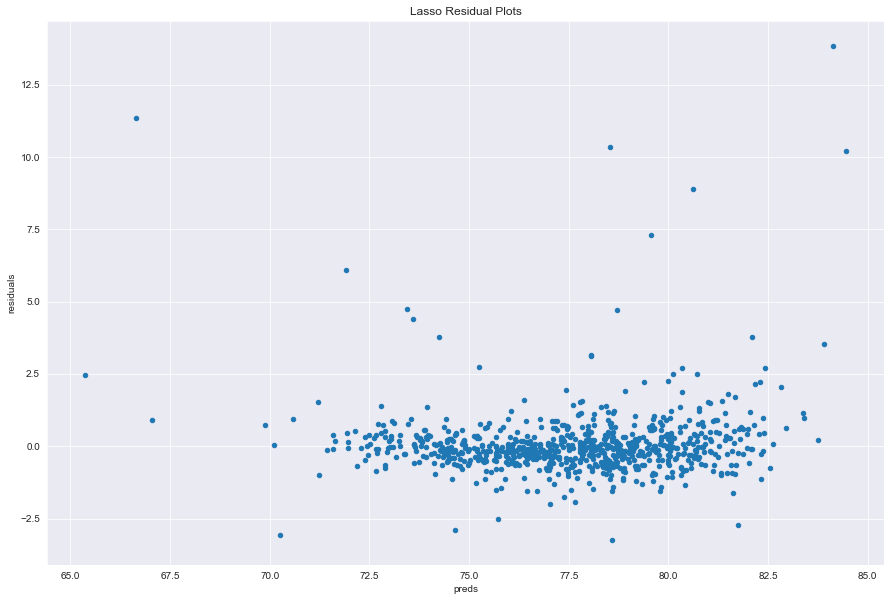

In [55]:
preds = pd.DataFrame({"preds":final_lasso.predict(X_test), "true":y_test})
preds["residuals"] = preds["true"] - preds["preds"]

preds.plot(x = "preds", y = "residuals", kind = "scatter", figsize=(15,10))
plt.title('Lasso Residual Plots')
plt.show()

In [56]:
Lasso_OLS = OLS(y_train, add_constant(X_train[final_coef.index])).fit()

Lasso_predictions = Lasso_OLS.predict(add_constant(X_test[final_coef.index]))
Lasso_train_r2 = Lasso_OLS.rsquared

Lasso_test_r2 = r2_score(y_test, Lasso_predictions)

In [57]:
Lasso_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Life_expectancy   R-squared:                       0.892
Model:                            OLS   Adj. R-squared:                  0.891
Method:                 Least Squares   F-statistic:                     1074.
Date:                Mon, 13 Jan 2020   Prob (F-statistic):               0.00
Time:                        10:37:32   Log-Likelihood:                -3265.8
No. Observations:                2356   AIC:                             6570.
Df Residuals:                    2337   BIC:                             6679.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
const                                 88.6282      0.332    266.855      0.000      87.977      89.279
Income_inequality                      0.1858      0.034      5.520      0.000       0.120       0.252
Teen_births                            0.0065      0.002      3.011      0.003       0.002       0.011
Social_associations                    0.0078      0.003      2.538      0.011       0.002       0.014
HIV_prevalence                         0.0006      0.000      4.099      0.000       0.000       0.001
Premature_death                    -1.006e-05   2.86e-05     -0.352      0.725   -6.62e-05    4.61e-05
Median_household_income             1.134e-05   2.39e-06      4.751      0.000    6.66e-06     1.6e-05
Population                          1.454e-07   6.73e-08      2.161      0.031    1.35e-08    2.77e-07
Preventable_hospital_stays         -1.443e-05   1.24e-05     -1.166      0.244   -3.87e-05    9.84e-06
Firearm_fatalities                    -0.0013      0.004     -0.291      0.771      -0.010       0.007
Sexually_transmitted_infections       -0.0004      0.000     -3.370      0.001      -0.001      -0.000
Violent_crime                         -0.0004      0.000     -2.805      0.005      -0.001      -0.000
Motor_vehicle_crash_deaths            -0.0049      0.003     -1.528      0.127      -0.011       0.001
Drug_overdose_deaths                  -0.0041      0.003     -1.485      0.138      -0.010       0.001
Injury_deaths                         -0.0009      0.001     -0.664      0.507      -0.004       0.002
Child_mortality                       -0.0074      0.001     -5.785      0.000      -0.010      -0.005
Premature_age-adjusted_mortality      -0.0233      0.001    -32.081      0.000      -0.025      -0.022
Food_environment_index                -0.1686      0.024     -6.904      0.000      -0.217      -0.121
Air_pollution_-_particulate_matter    -0.1356      0.013    -10.719      0.000      -0.160      -0.111
==============================================================================
Omnibus:                     2320.634   Durbin-Watson:                   2.013
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           179633.943
Skew:                           4.575   Prob(JB):                         0.00
Kurtosis:                      44.787   Cond. No.                     5.90e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.9e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [58]:
all_model_summary_df.loc[all_model_summary_df.model == 'Embedded - Lasso', 'n_features'] = len(Lasso_OLS.pvalues)
all_model_summary_df.loc[all_model_summary_df.model == 'Embedded - Lasso', 'AIC'] = Lasso_OLS.aic
all_model_summary_df.loc[all_model_summary_df.model == 'Embedded - Lasso', 'R2_test'] = Lasso_test_r2
all_model_summary_df.loc[all_model_summary_df.model == 'Embedded - Lasso', '>0.05_pvalues'] = sum(Lasso_OLS.pvalues > 0.05)

In [59]:
all_model_summary_df

,model,R2_test,AIC,n_features,>0.05_pvalues
0,Baseline,0.839762,6211.72,63,40
1,Basic - Top Correlation,0.817139,6700.37,6,0
2,Filter,0.782496,7239.67,22,4
3,Wrappper - RFE,0.84,6210.68,62,39
4,Wrappper - Stepwise,0.838352,6366.06,15,0
5,Embedded - Lasso,0.831321,6569.66,19,6


In [60]:
X2 = X_train[final_coef.index]
X2['Intercept'] = 1

vif = pd.DataFrame()
vif["variables"] = X2.columns
vif["VIF"] = [variance_inflation_factor(X2.values, i) for i in range(X2.shape[1])]

vif

,variables,VIF
0,Income_inequality,1.548465
1,Teen_births,2.624242
2,Social_associations,1.214306
3,HIV_prevalence,1.576979
4,Premature_death,14.887450
5,Median_household_income,2.544532
6,Population,1.303605
7,Preventable_hospital_stays,1.384703
8,Firearm_fatalities,1.590554
9,Sexually_transmitted_infections,1.905059


Apply the 20 selected features from the lasso model into our usual OLS model to obtain further information

In [61]:
final_lasso_test_r2 = statsmodel_regression(X_train[final_coef.index], add_constant(X_test[final_coef.index]), y_train, y_test)[0]
final_lasso_estimator = statsmodel_regression(X_train[final_coef.index], add_constant(X_test[final_coef.index]), y_train, y_test)[1]

In [62]:
final_lasso_estimator.pvalues > 0.05

const                                 False
Income_inequality                     False
Teen_births                           False
Social_associations                   False
HIV_prevalence                        False
Premature_death                        True
Median_household_income               False
Population                            False
Preventable_hospital_stays             True
Firearm_fatalities                     True
Sexually_transmitted_infections       False
Violent_crime                         False
Motor_vehicle_crash_deaths             True
Drug_overdose_deaths                   True
Injury_deaths                          True
Child_mortality                       False
Premature_age-adjusted_mortality      False
Food_environment_index                False
Air_pollution_-_particulate_matter    False
dtype: bool

In [63]:
all_model_summary_df.loc[all_model_summary_df.model == 'Embedded - Lasso', 'n_features'] = len(final_lasso_estimator.pvalues)
all_model_summary_df.loc[all_model_summary_df.model == 'Embedded - Lasso', 'AIC'] = final_lasso_estimator.aic
all_model_summary_df.loc[all_model_summary_df.model == 'Embedded - Lasso', 'R2_test'] = final_lasso_test_r2
all_model_summary_df.loc[all_model_summary_df.model == 'Embedded - Lasso', '>0.05_pvalues'] = sum(final_lasso_estimator.pvalues > 0.05)

In [64]:
all_model_summary_df

,model,R2_test,AIC,n_features,>0.05_pvalues
0,Baseline,0.839762,6211.72,63,40
1,Basic - Top Correlation,0.817139,6700.37,6,0
2,Filter,0.782496,7239.67,22,4
3,Wrappper - RFE,0.84,6210.68,62,39
4,Wrappper - Stepwise,0.838352,6366.06,15,0
5,Embedded - Lasso,0.83,6569.66,19,6
